In [1]:
# Author Joschua Jakubek
# Date 27.06.2024
#
# DICLAIMER
# 
# Individual sections of this code are inspired by the following sources:
#
# Pytorch DQN Tutorial: "https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"
#
# AI lecture by Prof Dr Maximilian Scherer: DQN Example "https://github.com/maschere/ai-lecture/blob/main/dqnExample.py"
# + additions from the lecture
#
# RL lecture by Janina Patzer: DQN Code Notebook "chapter_09.ipynb"
# 
# Shruti Dhumne DQN Tutorial: "https://medium.com/@shruti.dhumne/deep-q-network-dqn-90e1a8799871"
#
# For the implementation, improvement and formatting of individual code sections,
# the AI tools GitHub-Copilot and ChatGPT were used for support.

In [2]:
# Standard library imports
import math
import random
from os import makedirs
from itertools import count
from collections import namedtuple, deque

# Third-party library imports
import optuna
import numpy as np
import pandas as pd
from tqdm import tqdm
import gymnasium as gym
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

In [3]:
# Initialize the global variable `steps_done` to 0
steps_done = 0

In [4]:
# Set seeds for reproducibility
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 42
seed_all(seed)

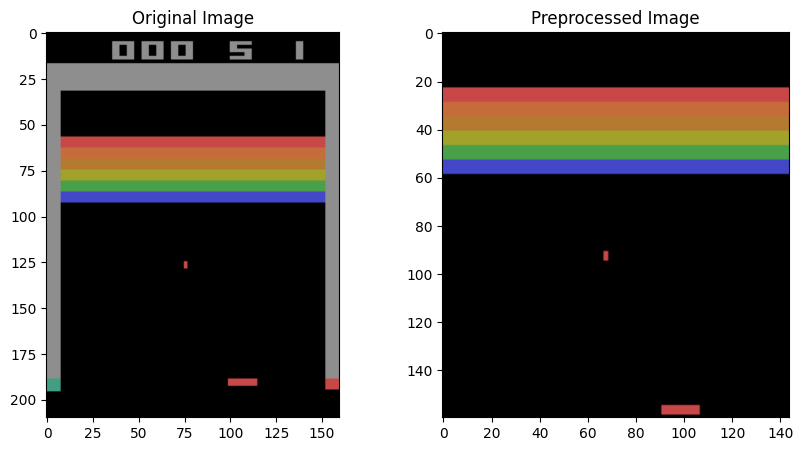

In [5]:
# Function to preprocess the image by cutting out relevant parts
def image_preprocessing(image):
    # Cut out the score area and gray borders
    image = image[34:34 + 160, 8:-8]
    
    # Reorder dimensions and convert to float32
    image = image.transpose(2, 0, 1).astype(np.float32)
    
    # Return the image as a tensor
    return torch.tensor(image)

# Create test environment
env = gym.make('ALE/Breakout-v5')
obs, info = env.reset(seed=seed)
obs, reward, terminated, truncated, info = env.step(1)

# Plot the original and preprocessed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(obs)
ax[0].set_title('Original Image')
ax[1].imshow(image_preprocessing(obs).permute(1, 2, 0).int())
ax[1].set_title('Preprocessed Image')

# Save the game size
game_size = image_preprocessing(obs).shape

# Close the test environment
env.close()

In [6]:
# Custom transition tuple for storing the state, action, next_state, and reward
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Replay memory class
class ReplayMemory:
    # Initialize the replay memory using a deque with maximum capacity 
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    # Push a transition to the memory
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Sample a batch of transitions from the memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # Return the length of the memory
    def __len__(self):
        return len(self.memory)

In [7]:
# DQN class for Atari Breakout using PyTorch
class AtariBreakoutDQN(nn.Module):

    def __init__(self, eps_start, eps_end, eps_decay, model_sum=False):
        # Initialize the superclass
        super(AtariBreakoutDQN, self).__init__()
        
        # Epsilon-greedy parameters
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.eps_diff = eps_start - eps_end
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=6, stride=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        
        # Fully connected layers
        conv_out_size = self._get_conv_out((3, 160, 144))
        self.fc1 = nn.Linear(in_features=conv_out_size, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=4)
        
        # Model summary
        if model_sum:
            summary(self, input_size=game_size)
    
    # Helper function to calculate the output size of the convolutional layers
    def _get_conv_out(self, shape):
        o = self.conv1(torch.zeros(1, *shape))
        o = self.conv2(o)
        o = self.conv3(o)
        o = self.conv4(o)
        return int(torch.prod(torch.tensor(o.size())))
    
    # Forward pass    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    # Epsilon-greedy action selection
    def choose_action(self, network_output, train=False):
        if train:
            global steps_done
            sample = random.random()
            eps_threshold = self.eps_end + self.eps_diff * math.exp(-1. * steps_done / self.eps_decay)
            steps_done += 1
            if sample > eps_threshold:
                with torch.no_grad():
                    return network_output.max(1)[1].view(1, 1)
            else:
                return torch.tensor([[random.randrange(4)]], dtype=torch.int64)
        else:
            with torch.no_grad():
                return network_output.max(1)[1].view(1, 1)

In [8]:
def train_AtariBreakoutDQN(num_episodes, eps_start, eps_end, eps_decay, lr, buffer_size, batch_size, gamma, tau, beta, save=True, model_sum=True):
    # Initialize the logs
    loss_logs = []
    reward_logs = []
    step_logs = []
    
    # Create the environment
    env = gym.make('ALE/Breakout-v5')
    env.metadata['render_fps'] = 24
    
    # Create policy and target network
    policy_dqn = AtariBreakoutDQN(eps_start, eps_end, eps_decay, model_sum=model_sum)
    target_dqn = AtariBreakoutDQN(eps_start, eps_end, eps_decay)
    target_dqn.load_state_dict(policy_dqn.state_dict())
    
    # Create the optimizer and memory buffer
    optimizer = optim.RMSprop(policy_dqn.parameters(), lr=lr)
    memory = ReplayMemory(buffer_size)

    # Episode loop
    for episode in tqdm(range(num_episodes), unit='episode', desc='Training', leave=False):
        # Set the episode reward to zero
        reward_log = 0
        
        # Reset the environment and get the initial state
        obs, info = env.reset(seed=seed)
        obs, reward, terminated, truncated, info = env.step(1)
        state = image_preprocessing(obs).unsqueeze(0)
        
        # Get the initial number of lives
        lives = info['lives']
        
        # Step loop
        for step in count():
            # Choose an action
            action = policy_dqn.choose_action(policy_dqn(state), train=True)
            
            # Perform the action
            obs, reward, terminated, truncated, info = env.step(action)
            
            # Check if the number of lives has decreased
            if info['lives'] < lives:
                # Save the new number of lives
                lives = info['lives']
                
                # Press the start button
                obs, reward, terminated, truncated, info = env.step(1)
                
                # Set a negative reward for losing a life
                reward = -1
            
            # Add the step reward to the episode reward
            reward_log += reward
            
            # Reward to tensor
            reward = torch.tensor([reward], dtype=torch.float32)
            
            # If terminal state, next state is None
            if terminated:
                next_state = None
            else:
                next_state = image_preprocessing(obs).unsqueeze(0)
            
            # Push the observation transition to the memory
            memory.push(state, action, next_state, reward)
            
            # Update the state
            state = next_state
            
            # Model update
            # No training if the memory is not filled enough
            if len(memory) > batch_size:
                # Sample and batch transitions
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))
                
                # Create masks for non-final states
                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
                
                # Concatenate the non-final states
                non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
                
                # Concatenate the states, actions, and rewards
                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                reward_batch = torch.cat(batch.reward)
                
                # Get the Q values for the state-action pairs in the batches
                state_action_values = policy_dqn(state_batch).gather(1, action_batch)
                
                # Prepare the Q values for the next states
                next_state_values = torch.zeros(batch_size)
                with torch.no_grad():
                    # Get the max Q values for the non-final states
                    next_state_values[non_final_mask] = target_dqn(non_final_next_states).max(1).values
                    
                # Compute the expected Q values
                expected_state_action_values = (next_state_values * gamma) + reward_batch

                # Compute Huber loss
                criterion = nn.SmoothL1Loss(beta=beta)
                loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
                loss_logs.append(loss.detach().numpy())

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                
                # In-place gradient clipping
                torch.nn.utils.clip_grad_value_(policy_dqn.parameters(), 100)
                optimizer.step()
            
            # Model update
            
            # Get the current network parameters
            target_dqn_state_dict = target_dqn.state_dict()
            policy_dqn_state_dict = policy_dqn.state_dict()
            
            # Update the target network parameters using the policy network parameters and the target update rate
            for key in policy_dqn_state_dict:
                target_dqn_state_dict[key] = tau * policy_dqn_state_dict[key] + (1 - tau) * target_dqn_state_dict[key]
            target_dqn.load_state_dict(target_dqn_state_dict)
            
            # Break the episode if terminated or truncated
            if terminated or truncated:
                break
        
        # Append the episode reward to the reward logs
        reward_logs.append(reward_log)
        
        # Append the episode steps to the step logs
        step_logs.append(step)

    env.close()

    if save:
        # Create a directory for the model
        makedirs(f'train/atari_dqn_{num_episodes}', exist_ok=True)
        
        # Save logs as dataframes
        pd.DataFrame({'loss': loss_logs}).to_csv(f'train/atari_dqn_{num_episodes}/loss.csv')
        pd.DataFrame({'reward': reward_logs}).to_csv(f'train/atari_dqn_{num_episodes}/reward.csv')
        pd.DataFrame({'steps': step_logs}).to_csv(f'train/atari_dqn_{num_episodes}/steps.csv')
        
        # Save model as .pth file
        torch.save(policy_dqn, f'train/atari_dqn_{num_episodes}/model.pth')
        
        # Save parameters as .txt file
        with open(f'train/atari_dqn_{num_episodes}/params.txt', 'w') as file:
            file.write(f"""
                        num_episodes: {num_episodes} | 
                        eps_start: {eps_start} | 
                        eps_end: {eps_end} | 
                        eps_decay: {eps_decay} | 
                        buffer_size: {buffer_size} | 
                        batch_size: {batch_size} | 
                        gamma: {gamma} | 
                        tau: {tau} | 
                        lr: {lr} | 
                        beta: {beta} | 
                       """)
            file.close()
    
    return sum(reward_logs) / len(reward_logs), policy_dqn

In [9]:
def play_atari_breakout(model_path, video_path) -> None:
    # Load the model
    policy_dqn = torch.load(model_path)
    
    # Create the environment
    env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
    env.metadata['render_fps'] = 24
    env = gym.wrappers.RecordVideo(env, video_path, episode_trigger=lambda e: True)
    
    # Set the score tracker
    score = 0
    
    # Reset the environment, press start button, and get the initial state
    obs, info = env.reset(seed=seed)
    obs, reward, terminated, truncated, info = env.step(1)
    state = image_preprocessing(obs).unsqueeze(0)
    
    # Get the initial number of lives
    lives = info['lives']
    
    for t in count():
        # Choose the action with the policy network
        action = policy_dqn.choose_action(policy_dqn(state))
        
        # Take the action and observe the next state and reward
        obs, reward, terminated, truncated, info = env.step(action)
        if reward > 0:
            score += reward
        
        # Check if the number of lives has decreased
        if info['lives'] < lives:
            # Save the new number of lives
            lives = info['lives']
            
            # Press the start button
            obs, reward, terminated, truncated, info = env.step(1)
        
        # Set the next state
        state = image_preprocessing(obs).unsqueeze(0)
        
        # Check if the game is over
        if terminated or truncated:
            print(f'Game Over! Lives: {info["lives"]}, Score: {score}, Duration: {t} steps')
            break
    
    # Close the environment
    env.close()

In [10]:
# Parameters derived from the number of episodes
num_episodes = 32 # 64, 128, 256, 512, 1024
batch_size = num_episodes // 16
buffer_size = num_episodes * 50
eps_decay = num_episodes * 50

# Static parameters
eps_start = 0.95
eps_end = 0.05
lr = 1e-4
gamma = 0.95
tau = 0.005
beta = 1.0

# Set the steps done to zero
steps_done = 0

# Train the model
train_reward, model = train_AtariBreakoutDQN(num_episodes, eps_start, eps_end, eps_decay, lr, buffer_size, batch_size, gamma, tau, beta)

# Print train results
print(f"Total steps: {steps_done} | Average episode reward: {train_reward}")

# Play the game with the latest trained model
play_atari_breakout(f'train/atari_dqn_{num_episodes}/model.pth', f'play/atari_dqn_{num_episodes}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 39, 35]           1,544
            Conv2d-2           [-1, 16, 12, 10]           4,624
            Conv2d-3             [-1, 32, 5, 4]           8,224
            Conv2d-4             [-1, 64, 3, 2]          18,496
            Linear-5                 [-1, 1024]         394,240
            Linear-6                  [-1, 256]         262,400
            Linear-7                   [-1, 64]          16,448
            Linear-8                    [-1, 4]             260
Total params: 706,236
Trainable params: 706,236
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 0.12
Params size (MB): 2.69
Estimated Total Size (MB): 3.07
----------------------------------------------------------------


Total steps: 6381 | Average episode reward: -2.78125


c:\Users\a829688\AppData\Local\anaconda3\envs\rl\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\a829688\OneDrive - Eviden\Documents\DHBW\6 Sechstes Semester\Reinforcement Learning\Abgaben\rl_breakout\play\atari_dqn_32 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\a829688\OneDrive - Eviden\Documents\DHBW\6 Sechstes Semester\Reinforcement Learning\Abgaben\rl_breakout\play\atari_dqn_32\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\a829688\OneDrive - Eviden\Documents\DHBW\6 Sechstes Semester\Reinforcement Learning\Abgaben\rl_breakout\play\atari_dqn_32\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\a829688\OneDrive - Eviden\Documents\DHBW\6 Sechstes Semester\Reinforcement Learning\Abgaben\rl_breakout\play\atari_dqn_32\rl-video-episode-0.mp4
Game Over! Lives: 0, Score: 4.0, Duration: 277 steps


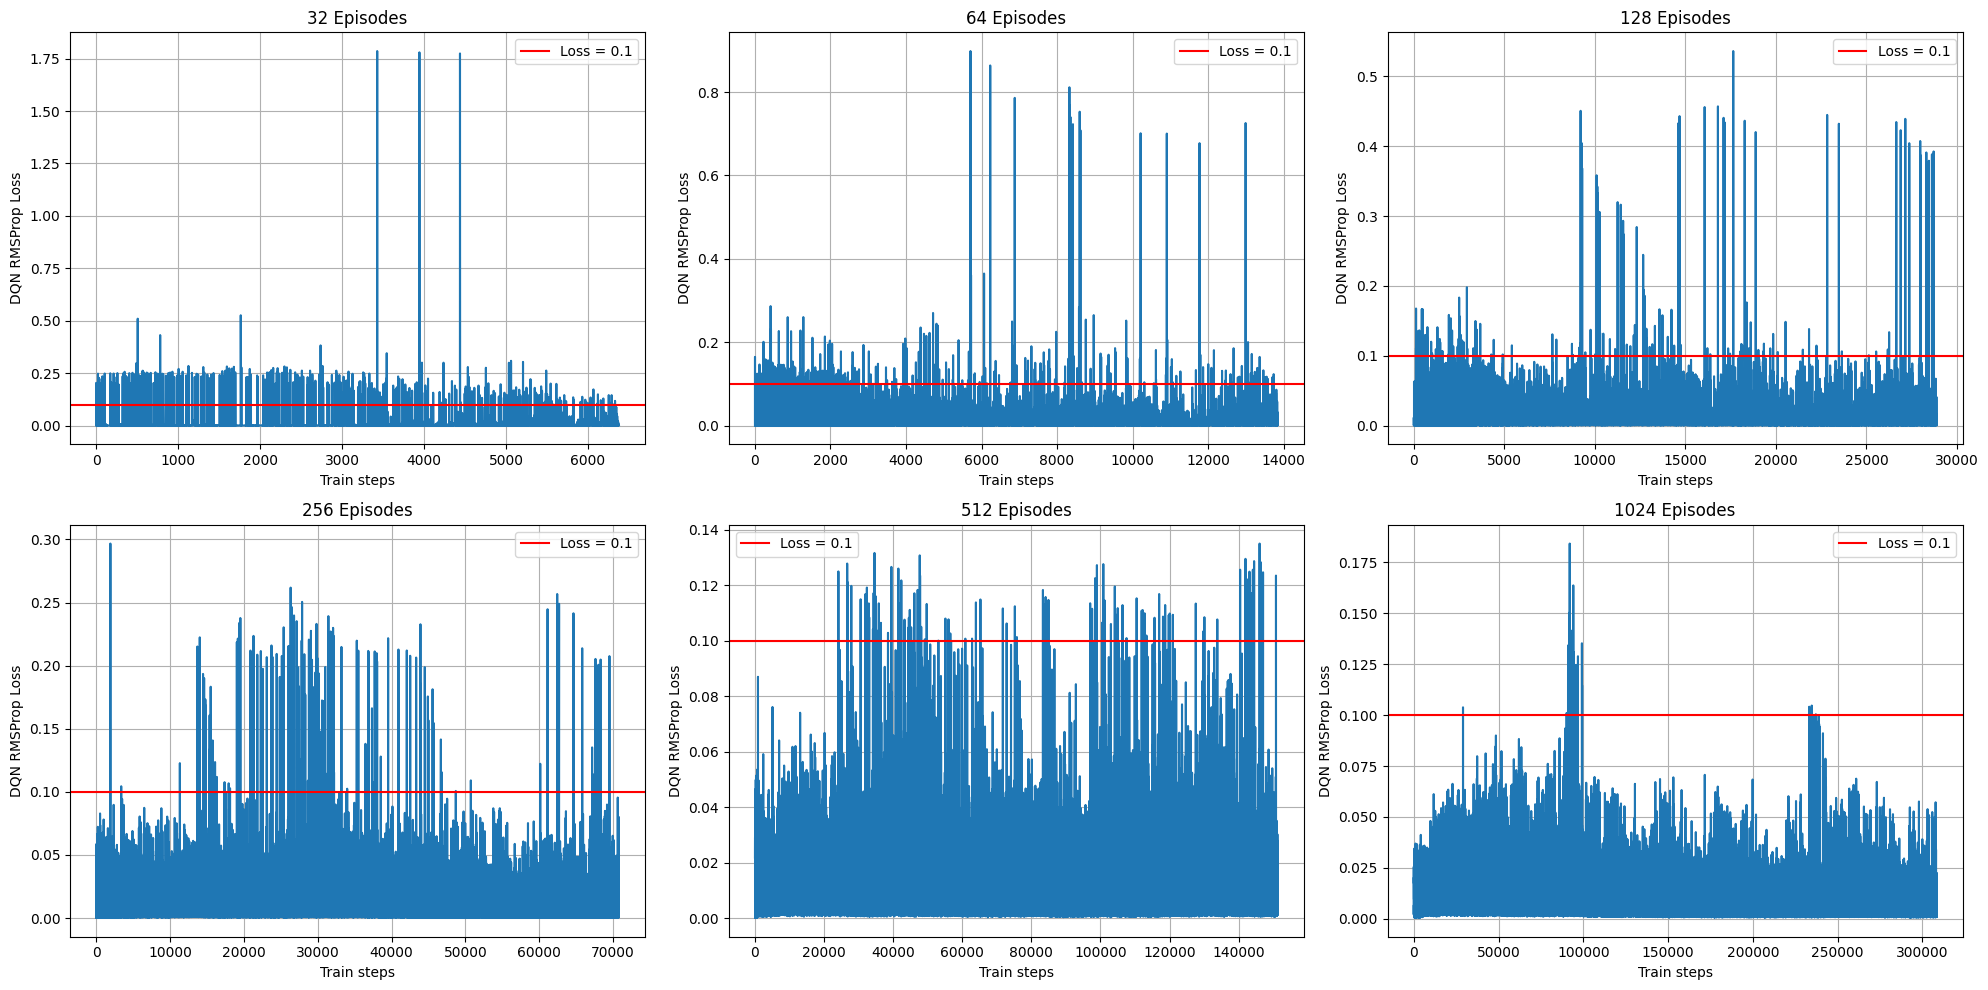

In [11]:
# Base directory where training data is saved
base_dir = 'train/atari_dqn_'

# Episodes for which loss values will be plotted
episodes = [32, 64, 128, 256, 512, 1024]

# Lists to store training steps and loss values for each episode
x_values = []
loss_values = []

# Iterate over each episode to read loss values from respective CSV files
for episode in episodes:
    # Read loss values from CSV file and create array for training steps
    loss = pd.read_csv(f'{base_dir}{episode}/loss.csv', index_col=0)
    x = np.arange(len(loss))
    
    # Update lists
    loss_values.append(loss)
    x_values.append(x)

# Create a grid of plots (2 rows, 3 columns) for each episode
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Iterate over plots and plot loss values for each episode
for i in range(len(x_values)):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax[row, col].plot(x_values[i], loss_values[i]['loss'])  # Plot loss values
    ax[row, col].axhline(y=0.1, color='r', linestyle='-', label='Loss = 0.1')  # Horizontal line for Loss = 0.1
    ax[row, col].set_title(f'{episodes[i]} Episodes')  # Set title
    ax[row, col].set_xlabel('Train steps')  # Set x-axis label
    ax[row, col].set_ylabel('DQN RMSProp Loss')  # Set y-axis label
    ax[row, col].legend()  # Add legend
    ax[row, col].grid()  # Add grid lines

# Optimize layout and save the image as a PNG file
plt.tight_layout()
plt.savefig('train/loss.png', dpi=500)

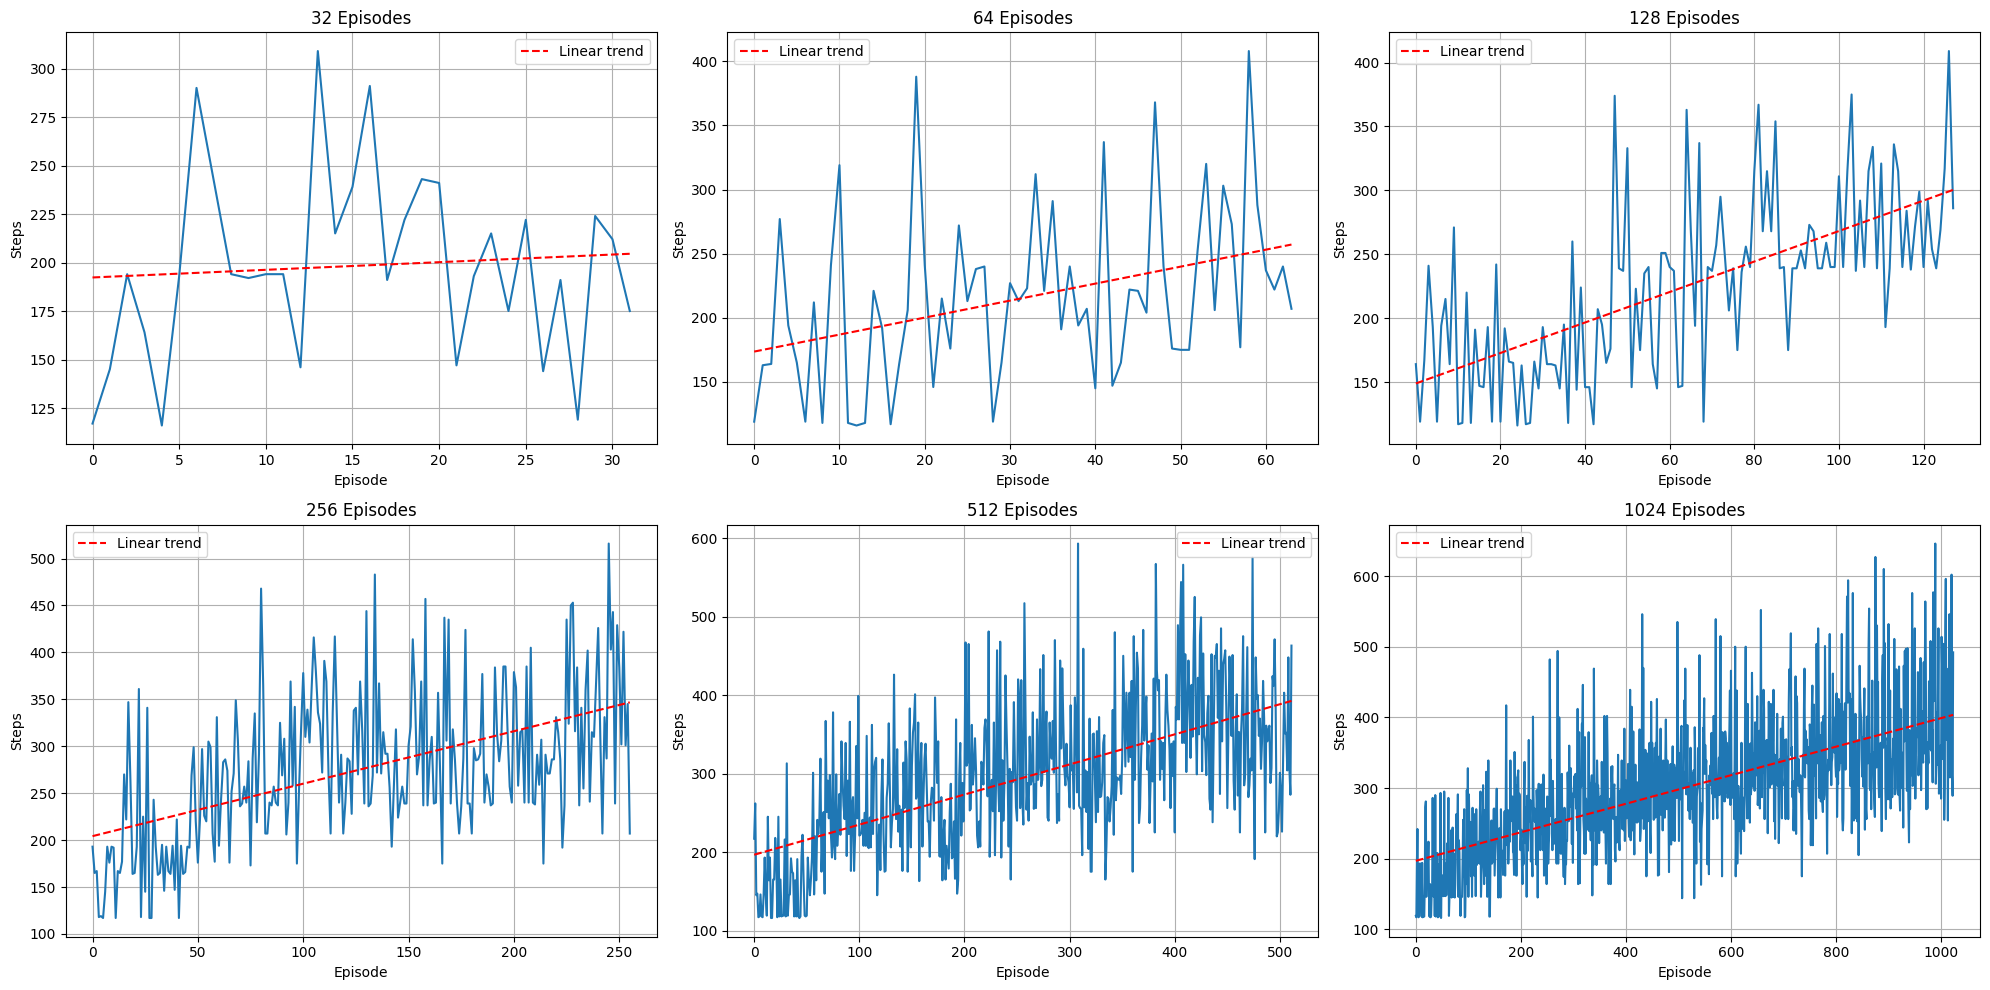

In [12]:
# Base directory where training data is saved
base_dir = 'train/atari_dqn_'

# Episodes for which step values will be plotted
episodes = [32, 64, 128, 256, 512, 1024]

# Lists to store episode numbers and step values for each episode
x_values = []
step_values = []

# Iterate over each episode to read step values from respective CSV files
for episode in episodes:
    # Read step values from CSV file and create array for episode numbers
    steps = pd.read_csv(f'{base_dir}{episode}/steps.csv', index_col=0)
    x = np.arange(len(steps))
    
    # Update lists
    step_values.append(steps)
    x_values.append(x)

# Create a grid of plots (2 rows, 3 columns) for each episode
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Iterate over plots and plot step values for each episode
for i in range(len(x_values)):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax[row, col].plot(x_values[i], step_values[i]['steps'])  # Plot step values
    # Fit a linear trendline to the step values and plot it
    z = np.polyfit(x_values[i], step_values[i]['steps'], 1)
    p = np.poly1d(z)
    ax[row, col].plot(x_values[i], p(x_values[i]), "r--", label="Linear trend")
    ax[row, col].set_title(f'{episodes[i]} Episodes')  # Set title
    ax[row, col].set_xlabel('Episode')  # Set x-axis label
    ax[row, col].set_ylabel('Steps')  # Set y-axis label
    ax[row, col].legend()  # Add legend
    ax[row, col].grid()  # Add grid lines

# Optimize layout and save the image as a PNG file
plt.tight_layout()
plt.savefig('train/steps.png', dpi=500)

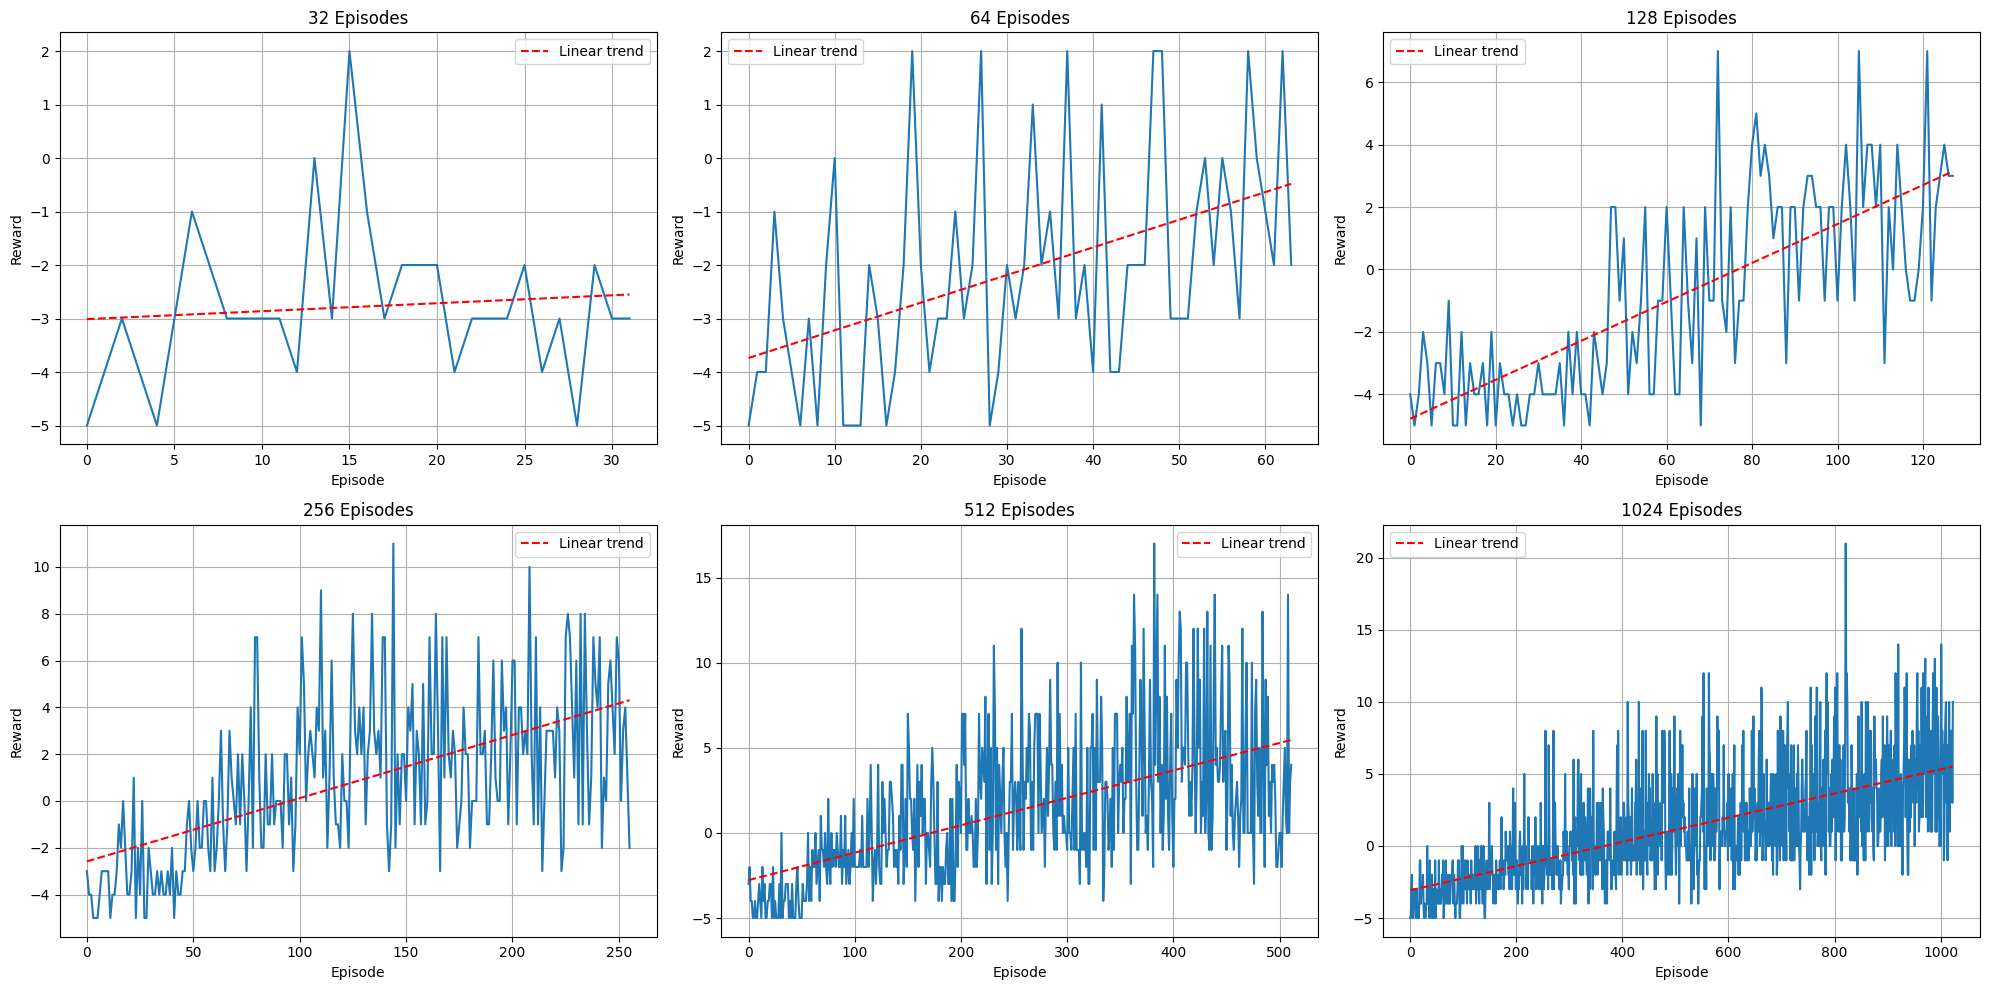

In [13]:
# Base directory where training data is saved
base_dir = 'train/atari_dqn_'

# Episodes for which reward values will be plotted
episodes = [32, 64, 128, 256, 512, 1024]

# Lists to store episode numbers and reward values for each episode
x_values = []
reward_values = []

# Iterate over each episode to read reward values from respective CSV files
for episode in episodes:
    # Read reward values from CSV file and create array for episode numbers
    reward = pd.read_csv(f'{base_dir}{episode}/reward.csv', index_col=0)
    x = np.arange(len(reward))
    
    # Update lists
    reward_values.append(reward)
    x_values.append(x)

# Create a grid of plots (2 rows, 3 columns) for each episode
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Iterate over plots and plot reward values for each episode
for i in range(len(x_values)):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax[row, col].plot(x_values[i], reward_values[i]['reward'])  # Plot reward values
    # Fit a linear trendline to the reward values and plot it
    z = np.polyfit(x_values[i], reward_values[i]['reward'], 1)
    p = np.poly1d(z)
    ax[row, col].plot(x_values[i], p(x_values[i]), 'r--', label='Linear trend')
    ax[row, col].set_title(f'{episodes[i]} Episodes')  # Set title
    ax[row, col].set_xlabel('Episode')  # Set x-axis label
    ax[row, col].set_ylabel('Reward')  # Set y-axis label
    ax[row, col].legend()  # Add legend
    ax[row, col].grid()  # Add grid lines

# Optimize layout and save the image as a PNG file
plt.tight_layout()
plt.savefig('train/reward.png', dpi=500)

In [14]:
# Create a directory for Optuna results
makedirs('optuna', exist_ok=True)

# Initialize global variables (if needed)
steps_done = 0
best_model = -float('inf')  # Initialize best_model with negative infinity or appropriate value
steps_done_logs = []  # Initialize logs if needed
train_reward_logs = []  # Initialize logs if needed

# Define the objective function for Optuna
def objective(trial):
    global steps_done, best_model, steps_done_logs, train_reward_logs
    
    # Sample hyperparameters for the trial
    num_episodes = trial.suggest_int('num_episodes', 500, 1000)
    batch_size = trial.suggest_int('batch_size', 10, 100)
    buffer_size = trial.suggest_int('buffer_size', 1000, 15000)
    eps_decay = trial.suggest_int('eps_decay', 1000, 100000)
    
    eps_start = trial.suggest_float('eps_start', 0.75, 1)
    eps_end = trial.suggest_float('eps_end', 0, 0.25)
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    gamma = trial.suggest_float('gamma', 0.75, 1)
    tau = trial.suggest_float('tau', 1e-3, 1)
    beta = trial.suggest_float('beta', 0.1, 10)
    
    # Set steps_done to zero before training
    steps_done = 0
    
    # Train the model and get the average reward
    train_reward, model = train_AtariBreakoutDQN(num_episodes, eps_start, eps_end, eps_decay, lr, buffer_size, batch_size, gamma, tau, beta, save=False, model_sum=False)
    
    # Check if the current model is the best found so far
    if train_reward > best_model:
        # Update best_model and save the new best model, parameters, and gameplay
        best_model = train_reward
        
        # Save best reward to file
        with open('optuna/best_model.txt', 'w') as file:
            file.write(str(float(train_reward)))
        
        # Save best model as .pth file
        torch.save(model, 'optuna/best_model.pth')
        
        # Save best parameters to .txt file
        with open('optuna/best_params.txt', 'w') as file:
            file.write(f"""
                        num_episodes: {num_episodes} | 
                        eps_start: {eps_start} | 
                        eps_end: {eps_end} | 
                        eps_decay: {eps_decay} | 
                        buffer_size: {buffer_size} | 
                        batch_size: {batch_size} | 
                        gamma: {gamma} | 
                        tau: {tau} | 
                        lr: {lr} | 
                        beta: {beta} | 
                       """)
        
        # Play the game with the best model and save the gameplay
        play_atari_breakout('optuna/best_model.pth', 'optuna/best_model_play')
    
    return train_reward

In [ ]:
# Create a storage for the study
storage_name = "sqlite:///optuna/study.db"

# Read in the saved best score
try:
    with open('optuna/best_model.txt', 'r') as file:
        best_model = float(file.read())
except FileNotFoundError:
    best_model = -float('inf')

# Create or load the study
study = optuna.create_study(study_name='Atari_Breakout_DQN_optimization', direction='maximize', storage=storage_name, load_if_exists=True)

# Infinite optimization while loop
while True:
    # Start one optimization trial
    study.optimize(objective, n_trials=1, n_jobs=1)
    
    # Save the reward track after each trial
    reward_track = [trial.value for trial in study.trials]
    pd.DataFrame({'reward': reward_track}).to_csv('optuna/reward_track.csv')

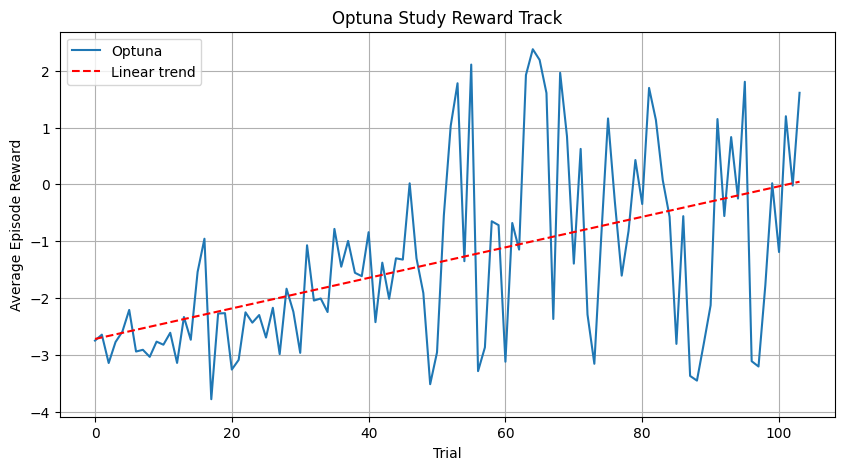

In [15]:
# Load the reward track data
study_reward_track = pd.read_csv('optuna/reward_track.csv', index_col=0).reset_index(drop=True)
x = np.arange(len(study_reward_track))

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, study_reward_track['reward'], label='Optuna')  # Plot the reward values
z = np.polyfit(x, study_reward_track['reward'], 1)
p = np.poly1d(z)
ax.plot(x, p(x), 'r--', label='Linear trend')  # Plot the linear trend line
ax.set_title('Optuna Study Reward Track')
ax.set_xlabel('Trial')
ax.set_ylabel('Average Episode Reward')
ax.legend()
ax.grid()

# Save the plot as a PNG file
plt.savefig('optuna/reward_track.png', dpi=500)